In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [115]:
df = pd.read_csv('./csv/express_app_stress_test_timeseries.csv')
df[df['metric_name'] == 'vus'][[ 'timestamp', 'metric_value']].groupby(df['timestamp']).median()

,timestamp,metric_value
timestamp,,
1691585223,1.691585e+09,2.0
1691585224,1.691585e+09,4.0
1691585225,1.691585e+09,5.0
1691585226,1.691585e+09,7.0
1691585227,1.691585e+09,9.0
...,...,...
1691585398,1.691585e+09,8.0
1691585399,1.691585e+09,7.0
1691585400,1.691585e+09,4.0


In [73]:
## Function that accepts a CSV file path as an argument and returns a dataframe.
## Dataframe has a 'timestamp' column and 'metric_value' column that corresponds to http_req_duration
def create_timeseries_df(csv_file_path):
    """
    Creates a timeseries dataframe from a csv path. 

    Args:
     * csv_file_path - string path. 

    Returns:
     * Pandas DF
    
    """
    timeseries_df = pd.read_csv(csv_file_path)
    timeseries_df = timeseries_df[['metric_name', 'timestamp', 'metric_value']]
    timeseries_df = timeseries_df[timeseries_df['metric_name'] == 'http_req_duration'][['timestamp', 'metric_value']]
    timeseries_df = timeseries_df.groupby(timeseries_df['timestamp']).median()
    timeseries_df = timeseries_df.reset_index()
    return timeseries_df

In [118]:
## Function that accepts a CSV file path as an argument and returns a dataframe. 
## Dataframe has a 'timestamp' column a 'metric_value' column that corresponds to vus (virtual users - another name for active users
## making a request to the API
def create_vus_df(csv_file_path):
    """
    Creates a vus dataframe from a csv path

    Args:
     * csv_file_path - string path

    Returns:
     * Pandas df
    """
    vus_df = pd.read_csv(csv_file_path)
    vus_df = vus_df[['metric_name', 'timestamp', 'metric_value']]
    vus_df = vus_df[vus_df['metric_name'] == 'vus'][['timestamp', 'metric_value']]
    vus_df = vus_df.groupby(vus_df['timestamp']).median()
    vus_df = vus_df.reset_index()
    return vus_df

In [119]:
create_vus_df('./csv/express_app_timeseries.csv').head()

,timestamp,metric_value
0,1691580922,4.0
1,1691580923,7.0
2,1691580924,10.0
3,1691580925,14.0
4,1691580926,17.0


In [90]:
# Function that accepts a summary output file and an application name and outputs a dataframe 
# Json must be formatted as summary output data by k6
# Accepts a path to the json file
def create_summary_output_df(json_file_path, app_name):
    summary_data = {}
    with open(json_file_path, "r") as json_file:
        json_dict = json.load(json_file)
        summary_data['Req Failed %'] = {app_name: json_dict['metrics']['http_req_failed']['values']['rate']}
        summary_data['Med Duration (ms)'] = {app_name: json_dict['metrics']['http_req_duration']['values']['med']}
        summary_data['p95 (ms)'] = {app_name: json_dict['metrics']['http_req_duration']['values']['p(95)']}
        summary_data['p99 (ms)'] = {app_name: json_dict['metrics']['http_req_duration']['values']['p(99)']}
    return pd.DataFrame(summary_data)
        

In [131]:
express_timeseries_df = create_timeseries_df('./csv/express-load-timeseries.csv')
fastapi_timeseries_df = create_timeseries_df('./csv/fastapi-load-timeseries.csv')

#express_stress_test_timeseries_df = create_timeseries_df('./csv/express_app_stress_test_timeseries.csv')
#fastapi_stress_test_timeseries_df = create_timeseries_df('./csv/fastapi_app_stress_test_timeseries.csv')

In [138]:
def create_latency_comparison_timeseries_chart(duration_df1, duration_df2, title, test_name="load"):
    """
    Creates and saves a latency comparison table with labels 'Express' and 'FastAPI'. 

    Args:
     * duration_df1, duration_df2: Pandas dfs with column names 'timestamp' and 'metric_value'
     * title: str - Title of figure
     * test_name: 'stress', 'load', or 'spike' test. Determines file name of saved image

    Returns:
     None

    """
    timeseries1 = duration_df1['timestamp'].apply(lambda x: x - duration_df1['timestamp'][0])
    timeseries2 = duration_df2['timestamp'].apply(lambda x: x - duration_df2['timestamp'][0])
    fig, (ax1, ax2, ax3) = plt.subplots(3,1)
    ax2.plot(timeseries1, duration_df1['metric_value'], label="Express")
    ax2.plot(timeseries2, duration_df2['metric_value'], label="FastAPI")
    ax2.set_ylabel('Latency (millisecond / request)')
    ax2.set_xlabel('Time Elapsed (s)')
    ax2.set_xticks([0, 30, 60, 90, 120, 150, 180], labels=['0s', '30s', '60s', '90s', '120s', '150s', '180s'])
    ax2.legend()
    ax2.set_title(title)
    df = create_summary_output_df('./summary_outputs/summary_output_load_express.json', 'Express')
    df2 = create_summary_output_df('./summary_outputs/summary_output_load_fastapi.json', 'FastAPI')
    df3 = pd.concat([df, df2])
    ax1.axis('off')
    ax1.set_title('Duration Summary')
    ax1.table(cellText=df3.values, colLabels=df3.columns, rowLabels=['Express', 'FastAPI'], loc='center')
    vus_df = create_vus_df('./csv/express-load-timeseries.csv')
    timeseries3 = vus_df['timestamp'].apply(lambda x: x - vus_df['timestamp'][0])
    ax3.plot(timeseries3, vus_df['metric_value'], label="VUs")
    fig.savefig(f"./{test_name}_test_comparison_timeseries.png")
    plt.show()

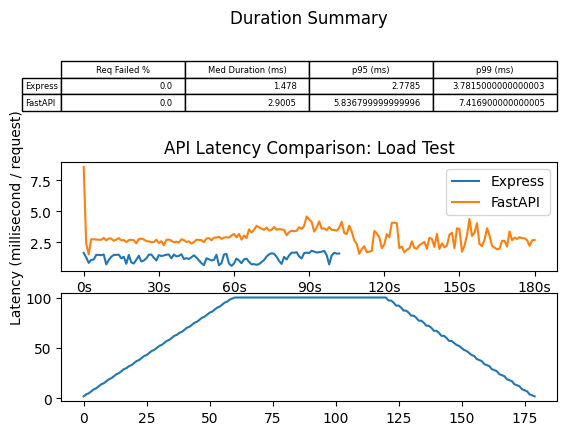

In [139]:
create_latency_comparison_timeseries_chart(express_timeseries_df, fastapi_timeseries_df, "API Latency Comparison: Load Test", 'stress')

In [ ]:
df = pd.DataFrame({'http_req_duration_99': {'FastAPI': 1, 'Express':3}, 'http_req_duration_med': {'FastAPI': 2, 'Express': 2}})
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=df.values, colLabels=df.columns, loc='top', rowLabels=["FastAPI", "Express"])
ax.set_title('Overall Metric')

fig.tight_layout()

plt.show()

In [53]:
import json

In [63]:
data = {}
with open('./summary_outputs/summary_output_load_express.json', 'r') as file:
    my_dict = json.load(file)
    print(my_dict['metrics'])
    data['Req Failed %'] = {'Express': my_dict['metrics']['http_req_failed']['values']['rate']}
    data['Med Duration (ms)'] = {'Express': my_dict['metrics']['http_req_duration']['values']['med']}
    data['p95 (ms)'] = {'Express': my_dict['metrics']['http_req_duration']['values']['p(95)']}
    data['p99 (ms)'] = {'Express': my_dict['metrics']['http_req_duration']['values']['p(99)']}
pd.DataFrame(data)
    

{'http_req_duration': {'values': {'p(95)': 2.2616499999999995, 'med': 1.483, 'p(99)': 2.684}, 'type': 'trend', 'contains': 'time'}, 'iteration_duration': {'type': 'trend', 'contains': 'time', 'values': {'med': 1002.817636, 'p(99)': 1003.5067465, 'p(95)': 1003.2230956}}, 'iterations': {'values': {'count': 12048, 'rate': 66.75268203333944}, 'type': 'counter', 'contains': 'default'}, 'http_reqs': {'values': {'count': 12048, 'rate': 66.75268203333944}, 'type': 'counter', 'contains': 'default'}, 'http_req_failed': {'values': {'passes': 0, 'fails': 12048, 'rate': 0}, 'type': 'rate', 'contains': 'default'}}


,Req Failed %,Med Duration (ms),p95 (ms),p99 (ms)
Express,0,1.483,2.26165,2.684
